In [3]:
# | code-fold: hide

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.stats import qmc
from sklearn.datasets import fetch_openml
from sklearn.model_selection import ParameterGrid, train_test_split
from tqdm.notebook import tqdm

In [4]:
# | code-fold: hide

set_matplotlib_formats("svg")
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_context(context="notebook", font_scale=1.5)


warnings.filterwarnings("ignore", category=FutureWarning)
FIGSIZE = (12, 6)
N_SAMPLES = 100

# Intro

We have all encountered this predicament. The moment when we believe our features are satisfactory, and we're ready to train our first model. Initially, we begin with the default settings of the model, which yields acceptable performance. However, to achieve superior results, we determine that hyperparameter tuning is necessary. Referring to the documentation of [Scikit-Learn](https://scikit-learn.org/stable/modules/classes.html#module-model_selection), there are several options: GridSearchCV and RandomizedSearchCV are the most common choices.


## GridSearch

GridSearchCV is a hyperparameter tuning method in Scikit-Learn that uses exhaustive search to find the best combination of estimator parameters. It tries all possible combinations of specified parameter values using cross-validation to evaluate each set. Pros include exhaustive exploration and handling various methods, providing detailed performance information. However, it is time-consuming and memory-intensive, as it tests all combinations. The choice of cross-validation method and number of folds significantly impacts results.


## RandomSearch

RandomizedSearchCV is a hyperparameter tuning method in Scikit-Learn that uses random sampling to search for the best combination of estimator parameters. Unlike GridSearchCV, which tries all possible combinations, it samples a fixed number of parameter settings from specified distributions. It is more efficient than exhaustive search but may not find the absolute best set of parameters. Cross-validation is used to evaluate each sampled set, and continuous or categorical distributions can be specified. The choice of distributions and iterations impacts results, as well as the cross-validation method and number of folds.


## Something in between

There are techniques called Latin Hypercube Sampling (LHS) or Poisson Discs sampling that mix grid and random sampling together.

Latin Hypercube Sampling is a deterministic, space-filling design technique that selects a representative sample from the parameter space by ensuring that every hyperrectangle enclosing each unique combination of parameters contains at least one sample. In simpler terms, LHS aims to provide a representative and uniform distribution of samples across the entire range of possible combinations.

Consider the analogy of a Sudoku puzzle. Each square on the board represents a unique combination of parameters. While you may be tempted to reveal all the numbers in one row or column, this would be an unwise move as it would limit the overall usefulness of your picks. LHS offers a framework for reducing the number of picks while maximizing their effectiveness, if you have selected a square from one row it would favor other rows more, the same logic applies to the columns and sub-squares.

![](artifacts/sudoku.png)

In conclusion, when choosing between hyperparameter tuning methods, it is essential to consider factors like computational resources, time constraints, and the complexity of the problem at hand. GridSearchCV provides exhaustive exploration but comes with higher computational costs, while RandomizedSearchCV offers flexibility and efficiency but may not find the absolute best combination of parameters. Latin Hypercube Sampling sampling offer a balance between these two extremes by providing representative samples while being more computationally efficient than GridSearchCV for large search spaces.


## visual represantation

To illustrate the distinction between the three sampling methods, let's consider a hypothetical scenario in a two-dimensional space, spanning from 0 to 1 inclusively and apply the three sampling strategies random, lhs, and grid.


In [5]:
# | code-fold: show
np.random.seed(42)

uni_sample = np.random.uniform(0, 1, (100, 2))

sampler = qmc.LatinHypercube(d=2, optimization="lloyd")
lhs_sample = sampler.random(n=100)

grid_sample = np.array(
    [[i, j] for i in np.linspace(0, 1, 10) for j in np.linspace(0, 1, 10)]
)

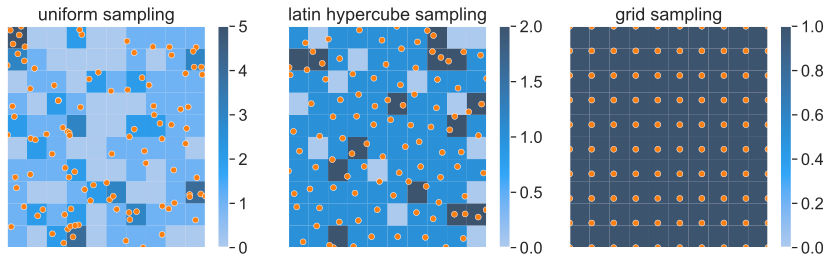

In [6]:
# | code-fold: hide

_, ax = plt.subplots(1, 3, figsize=(12, 4))


curr_ax = ax[0]
sns.histplot(
    x=uni_sample[:, 0], y=uni_sample[:, 1], bins=10, ax=curr_ax, cbar=True, thresh=None
)
sns.scatterplot(x=uni_sample[:, 0], y=uni_sample[:, 1], ax=curr_ax, color="tab:orange")
curr_ax.set_xticks([])
curr_ax.set_yticks([])
curr_ax.set_title("uniform sampling")


curr_ax = ax[1]
sns.histplot(
    x=lhs_sample[:, 0], y=lhs_sample[:, 1], bins=10, ax=curr_ax, cbar=True, thresh=None
)
sns.scatterplot(x=lhs_sample[:, 0], y=lhs_sample[:, 1], ax=curr_ax, color="tab:orange")
curr_ax.set_xticks([])
curr_ax.set_yticks([])
curr_ax.set_title("latin hypercube sampling")


curr_ax = ax[2]
sns.histplot(
    x=grid_sample[:, 0],
    y=grid_sample[:, 1],
    bins=10,
    ax=curr_ax,
    cbar=True,
    thresh=None,
)
sns.scatterplot(
    x=grid_sample[:, 0], y=grid_sample[:, 1], ax=curr_ax, color="tab:orange"
)
curr_ax.set_xticks([])
curr_ax.set_yticks([])
curr_ax.set_title("grid sampling")

plt.tight_layout()
plt.show()

# apply lhs to a real application

Lets put this knowledge into pratice by performing some hyper-parameter tuning of a catboost model on a [dataset](https://www.openml.org/search?type=data&status=active&id=1461)

The dataset is about direct marketing campaigns of a Portuguese banking institution, focusing on phone calls to promote term deposits. The data includes 17 input variables and one output variable. Input attributes consist of client demographics such as age, job type, marital status, education level, credit default status, average yearly balance, housing loan status, personal loan status, contact communication type, last contact day and month, duration of contact, number of contacts during the current campaign, number of days since last contact from a previous campaign, number of contacts before the current campaign, and the outcome of the previous marketing campaign. The goal is to predict if a client will subscribe to a term deposit based on these features.

This dataset is a binary classification problem where the goal is to predict if a client will subscribe to a term deposit based on multiple categorical and numerical features, making it an excellent use case for CatBoost, a gradient boosting library specifically designed to handle categorical data.


## dataset

We can utilize the [`fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html#sklearn.datasets.fetch_openml) function from scikit-learn to automatically fetch the appropriate dataset. Following this, the data will be split into train and test sets with stratification controlled on the target variable. That is, the distribution of the target variable (y) is maintained equal for both the training and testing sets.


In [ ]:
# | code-fold: show

# fetch data set
ID = 1461
X, y = fetch_openml(
    data_id=ID,
    data_home=f"openml_download_{ID}",
    return_X_y=True,
)

# downsample and create a stratified train test split
X = X.sample(frac=0.25)  # control the size of the dataset
X = X.dropna(axis=0, how="any")

# y = y.astype(int) - 1
y = y.loc[X.index]  # align the datasets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
)

## info on dataset

As mentioned earlier, the dataset comprises 9 categorical and 7 numerical features. This configuration makes the dataset well-suited for using CatBoost. CatBoost employs a specialized technique called "ordered target encoding" that converts categorical features into numerical values, rendering them amenable to gradient boosting models. This approach can result in enhanced model performance and accuracy compared to other machine learning algorithms, particularly when managing datasets replete with a substantial number of categorical features.


In [ ]:
# | code-fold: show

X.info()

## creating data pools

CatBoost provides an option to create pools of data. This feature allows CatBoost to optimize the handling of large files internally. In this specific case, defining categorical features in one place and being able to reuse them later is a benefit for improving reproducibility.


In [ ]:
# | code-fold: show

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=list(X.select_dtypes(include="category").columns),
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=list(X.select_dtypes(include="category").columns),
)

## Applying Three Sampling Techniques: Grid, Random, and LHS

In the following section, we apply and compare the results of the three sampling techniques: grid search, random search, and Latin Hypercube Sampling (LHS). The objective is to demonstrate that LHS explores more of the design space than random search while maintaining enough randomness to mitigate the symmetry issues inherent in grid search.

The search space is defined by the following parameters.

- depth $[1 \dotsc 15]$
- iterations $[1 \dotsc 1024]$
- subsample $[0.1,1]$
- bagging_temperatur $[1 \dotsc 1e6]$

The number of samples used is 100.


## grid search

To adhere to the limit of 100 samples, we use $100^{1/4}\approx 3$ this results in $3^4=81$ samples.


In [ ]:
# | code-fold: show

n_grid_samples = np.power(N_SAMPLES, 1 / 4)
n_grid_samples = np.floor(n_grid_samples).astype(int)

param_grid = {
    "depth": np.linspace(1, 15, n_grid_samples, dtype=int),
    "iterations": np.linspace(1, 1024, n_grid_samples, dtype=int),
    "subsample": np.linspace(0.1, 1, n_grid_samples, endpoint=False),
    "bagging_temperature": np.linspace(1, 1000000, n_grid_samples, dtype=int),
}

param_combo = list(ParameterGrid(param_grid=param_grid))

cube_search = []
start = time.time()
for param in tqdm(param_combo):
    cbc = CatBoostClassifier(
        **param,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    score = cbc.get_best_score().get("validation").get("F1")
    param["score"] = score
    param["iterations"] = cbc.get_best_iteration()

    cube_search.append(param)
end = time.time()
print(f"time lhs: {end - start:.2f} sec")
grid_results = pd.DataFrame(cube_search).sort_values(by="score", ascending=False)

In [ ]:
grid_results.head()

## Random search

for depth and iterations the model excpects integers, so `randint` is used and for subsample and bagging_temperature `uniform` is used, as the model accepts float values for those.


In [ ]:
# | code-fold: show
random_sample = np.hstack(
    (
        np.random.randint(1, 15, (N_SAMPLES, 1)),
        np.random.randint(1, 1024, (N_SAMPLES, 1)),
        np.random.uniform(0, 1, (N_SAMPLES, 1)),
        np.random.uniform(1, 1_000_000, (N_SAMPLES, 1)),
    )
)

param_combo = list(
    pd.DataFrame(
        data=random_sample,
        columns=["depth", "iterations", "subsample", "bagging_temperature"],
    )
    .to_dict("index")
    .values()
)


cube_search = []
start = time.time()
for param in tqdm(param_combo):
    cbc = CatBoostClassifier(
        **param,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    score = cbc.get_best_score().get("validation").get("F1")
    param["score"] = score
    param["iterations"] = cbc.get_best_iteration()

    cube_search.append(param)

end = time.time()
print(f"time random: {end - start:.2f} sec")
random_results = pd.DataFrame(cube_search).sort_values(by="score", ascending=False)

In [ ]:
# | code-fold: show

random_results.head()

## LHS search

when applying the LHS technqiue you need to specify how many dimensions the resulting sample should have and how many samples you want. these are on a different scale than the searchspace that you want to explore, so a scaling is applied to get it to the desired space. afterwhich a type conversion is applied.


In [ ]:
# | code-fold: show
sampler = qmc.LatinHypercube(d=4, optimization="lloyd")
sample = sampler.random(n=N_SAMPLES)

l_bounds = [1, 1, 0, 1]
u_bounds = [15, 1024, 1, 1000000]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# convert to int
sample_scaled[:, :2] = sample_scaled[:, :2].astype(int)


param_combo = list(
    pd.DataFrame(
        data=sample_scaled,
        columns=["depth", "iterations", "subsample", "bagging_temperature"],
    )
    .to_dict("index")
    .values()
)

cube_search = []
start = time.time()
for param in param_combo:
    cbc = CatBoostClassifier(
        **param,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    score = cbc.get_best_score().get("validation").get("F1")
    param["score"] = score
    param["iterations"] = cbc.get_best_iteration()

    cube_search.append(param)

end = time.time()
print(f"time lhs: {end - start:.2f} sec")
lhs_results = pd.DataFrame(cube_search).sort_values(by="score", ascending=False)

In [ ]:
# | code-fold: show

lhs_results.head()

## compare the three results


In [ ]:
# | code-fold: show

df_all_sample = pd.concat(
    [
        lhs_results.assign(sampling="lhs"),
        random_results.assign(sampling="random"),
        grid_results.assign(sampling="grid"),
    ],
    axis=0,
)

df_all_sample = df_all_sample.sort_values(by="score", ascending=False)

df_all_sample.head(n=10)

# Bonus: Optuna hyperparameter optimization framework

[Optuna](https://optuna.readthedocs.io/en/stable/)
bayes hyperparameter tuning, tradeoff between explotation and exploration


In [ ]:
# | code-fold: show


def obj_all(trial) -> float:
    params = {
        "depth": trial.suggest_int(name="depth", low=1, high=15),
        "iterations": trial.suggest_int("iterations", 1, 1024),
        "subsample": trial.suggest_float("subsample", 0, 1.0),
        "bagging_temperature": trial.suggest_float(
            "bagging_temperature", 1e-10, 1_000_000, log=True
        ),
    }

    cbc = CatBoostClassifier(
        **params,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    return cbc.get_best_score().get("validation").get("F1")


print("-" * 10)

start = time.time()
study = optuna.create_study(study_name="all-in", direction="maximize")
study.optimize(
    obj_all,
    n_trials=N_SAMPLES,
)

end = time.time()
print("-" * 10)
print(f"time all-in: {end - start:.2f} sec")
print(f"{study.best_params=}")
print(f"{study.best_value=}")

In [1]:
import gif

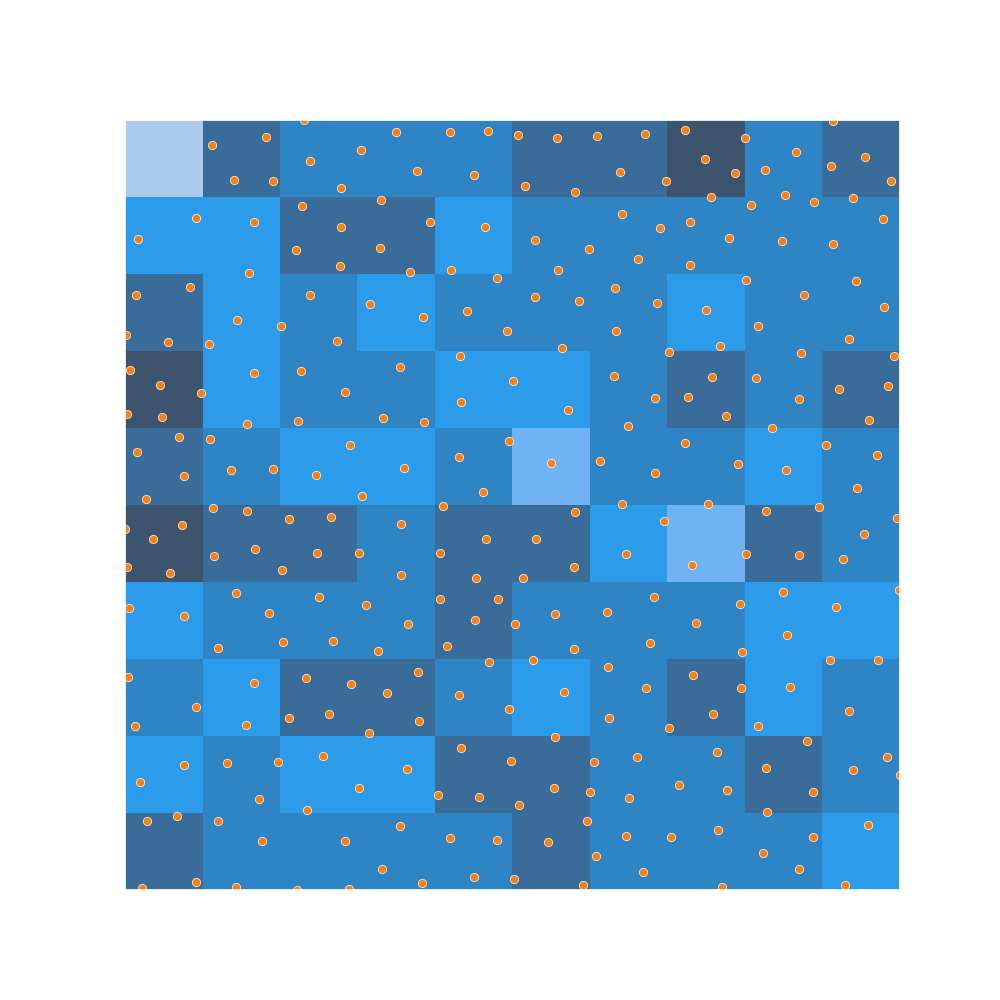

In [102]:
@gif.frame
def frame(sub_lhs_sample):
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    curr_ax = ax
    sns.histplot(
        x=sub_lhs_sample[:, 0],
        y=sub_lhs_sample[:, 1],
        bins=10,
        ax=curr_ax,
        cbar=False,
        thresh=None,
    )
    sns.scatterplot(
        x=sub_lhs_sample[:, 0],
        y=sub_lhs_sample[:, 1],
        ax=curr_ax,
        color="tab:orange",
        s=100,
    )
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])


# frame(lhs_sample)

In [106]:
sampler = qmc.LatinHypercube(d=2, optimization="lloyd")
lhs_sample = sampler.random(n=300)

n_slices = 33
inc = lhs_sample.shape[0] // n_slices

prev_i = 0
all_frames = []
for i in range(inc, lhs_sample.shape[0], inc):
    all_frames.append(frame(lhs_sample[prev_i:i, :]))

In [107]:
# add the bounce
# all_frames.extend([all_frames[-1] for _ in range(2)])
all_frames.extend(all_frames[::-1])

In [108]:
gif.save(all_frames, "artifacts/dots.gif", duration=100)